# Neighborhood_battle

In previous courses we have seen how to collect informations on a given city and its neighborhoods and cluster them according to their venues data from Foursquare.  
Now that we did the task for two cities, namely New York and Toronto, let's imagine a case where someone living in New York  wants to move to Toronto, Among many criterias (cost of life, crime rates...) he'll want to know wich neighborhood in Toronto is the most similar to his actual neighborhood in New York.  
This case can be generelized as long as we have bourough or neighborhood informations of city 1 and city 2 available. It could be a web service for neighborhood comparison websites, as long as the website provide the list of neighborhood and related information.  
This requires clustering neighborhoods of city 2 and comparing the clusters to the actual neighborhood in city 1. Then we will have to determin wich neighborhood in city 2 is the most similar to the actual neighborhood and at wihch percentage.

## Load needed libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

### Foursquare access

In [ ]:
# Foursquare 
CLIENT_ID = '<hidden>' # your Foursquare ID
CLIENT_SECRET = '<hidden>' # your Foursquare Secret
VERSION = '20190722' # Foursquare API version

## Define needed Functions

### Get Neighborhoods Venues

In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name, len(venues_list))
        #print(name)    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #print(results)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

### Get city address (later for map visualiziation)

In [32]:
def get_ll(address):
    # get address coordinates
    from geopy.geocoders import Nominatim
    geolocator = Nominatim(user_agent="address_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))
    return(latitude, longitude)

### One_hot transformation

In [33]:
def df_to_onehot(df):
    # one hot encoding
    df_onehot = pd.get_dummies(df[['Venue Category']], prefix="", prefix_sep="") 
    # rename any category named "Neighborhood"
    df_onehot.rename(columns={'Neighborhood': 'other'} , inplace=True)
    # add neighborhood column back to dataframe
    df_onehot['Neighborhood'] = df['Neighborhood'] 
    
    # move neighborhood column to the first column
    fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
    df_onehot = df_onehot[fixed_columns]
    
    # Average preseance of each category in each neighborhood appearance
    df_grouped=df_onehot.groupby('Neighborhood').mean().reset_index()
    return(df_grouped)

### Get the most frequent venues

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
def df_to_most_common_venues(df,num_top_venues):
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = df['Neighborhood']

    for ind in np.arange(df.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df.iloc[ind, :], num_top_venues)

    return(neighborhoods_venues_sorted)

## Intersection :

We will need this function to compare results later and find the shared venue categories.

In [64]:
# intesection of the lists
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

# Get Toronto and NY Neighborhoods and related Venues

Let's get Toronto neighborhoods information (with Latitude and Longitude)

In [117]:
tor_neigh=pd.read_csv('toronto_neighborhoods.csv')
tor_neigh.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


Now let's get the venues of each neighborhood using Foursquare

In [11]:
# get toronto neighborhood information
tor_neigh=pd.read_csv('toronto_neighborhoods.csv')
toronto_venues = getNearbyVenues(names=tor_neigh['Neighborhood'],
                                   latitudes=tor_neigh['Latitude'],
                                   longitudes=tor_neigh['Longitude']
                                  )


Now we will do the same thing with NY neighborhoods

In [8]:
ny_neigh=pd.read_csv('NY_neighborhoods.csv')
ny_neigh.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [12]:
ny_venues = getNearbyVenues(names=ny_neigh['Neighborhood'],
                                   latitudes=ny_neigh['Latitude'],
                                   longitudes=ny_neigh['Longitude']
                                  )

# Perform onehot transformation on venues categories and retreive most common venues

We will apply a one-hot transformation in order to have each venue category in a column and the compute the frequency of each category in the neighborhood:

In [44]:
tor_venu=df_to_onehot(toronto_venues)
print(tor_venu.shape)
tor_venu.head()

(101, 279)


,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,other,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Rich

Now the same thing with NY neighborhoods :

In [3]:
ny_venu=df_to_onehot(ny_venues)
print(ny_venu.shape)
ny_venu.head()

(302, 429)


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,other,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great 

# Mesure similarity

Now we have two ways to measure similarity :  
**Appoache 1** : Since we have a normalized frquency related to each category, we can use them as coordiantes of a vector, and then compute distances between each vector, in the end the best fit is the vector with the lowest distance.  
**Approache 2** : we will use the data of the selected neighborhood, and then add-it to the overall neighoborhoods of city 2, then make a clustering. 

## Comparing venue categories

Let's test if the categories are different between the cities (probably the case)

How many venue categories from Toronto exist in New York:

In [20]:
veneu_list=[]
for venue in tor_venu.columns:
    veneu_list.append(sum(ny_venu.columns==venue))

print('Rate of Toronto venue categories existing in New york : {:2.0f}%'.format(sum(veneu_list)*100/len(veneu_list)))

Rate of Toronto venue categories existing in New york : 88%


How many venue categories from New York exist in Toronto:

In [22]:
veneu_list=[]
for venue in ny_venu.columns:
    veneu_list.append(sum(tor_venu.columns==venue))

print('Rate of New york venue categories existing in Toronto : {:2.0f}%'.format(sum(veneu_list)*100/len(veneu_list)))

Rate of New york venue categories existing in Toronto : 57%


Based on the previous results, NY has a lot more venue categories, which implies that some categories in NY does not exist in toronto. We must then work on the common categories :

In [27]:
Common_venues=intersection(tor_venu.columns.drop('Neighborhood'), ny_venu.columns)
print('the number of common venues is {}'.format(len(Common_venues)))

the number of common venues is 245


Let's extarct only the Neighborhoods with the common venue categories for each city, we will use temporary variables :

In [28]:
# Toronto
tor_venu.set_index
tor_venu_temp0 = tor_venu.set_index('Neighborhood')[Common_venues]
tor_venu_temp0.reset_index(inplace=True)
tor_venu_temp0.head()

,Neighborhood,Smoothie Shop,Hookah Bar,Eastern European Restaurant,Health & Beauty Service,Brazilian Restaurant,Butcher,Mexican Restaurant,Other Great Outdoors,Construction & Landscaping,Event Space,Food Court,Gluten-free Restaurant,Japanese Restaurant,Jazz Club,Fountain,Strip Club,Comic Shop,Lounge,Scenic Lookout,BBQ Joint,Flower Shop,Organic Grocery,Poke Place,Video Game Store,Jewish Restaurant,Restaurant,Sandwich Place,Park,Lingerie Store,Health Food Store,Indian Restaurant,Southern / Soul Food Restaurant,Plaza,Bus Stop,Playground,Lake,Dumpling Restaurant,Ramen Restaurant,Opera House,Coffee Shop,Gastropub,Pool,Art Gallery,Café,Diner,Print Shop,Baseball Field,Baseball Stadium,Breakfast Spot,Sports Bar,Fast Food Restaurant,Food Truck,Pet Store,Basketball Court,Boat or Ferry,Brewery,Cheese Shop,Shopping Mall,Women's Store,Toy / Game Store,Beach,Metro Station,Music Store,Rental Car Location,Furniture / Home Store,Beer Store,Flea Market,Bookstore,Pharmacy,Indonesian Restaurant,Bistro,Warehouse Store,Chocolate Shop,Bakery,Burger Joint,Italian Restaurant,Vietnamese Restaurant,Auto Garage,Department Store,Yoga Studio,Accessories Store,Deli / Bodega,Cocktail Bar,General Entertainment,Greek Restaurant,Market,Museum,Bike Shop,Smoke Shop,Monument / Landmark,Persian Restaurant,Pub,Caribbean Restaurant,Dive Bar,Gym / Fitness Center,Fried Chicken Joint,Jewelry Store,Historic Site,Nightclub,Burrito Place,Beer Bar,Supplement Shop,Dog Run,Piano Bar,Tea Room,Hotel Bar,Electronics Store,Medical Center,Tailor Shop,Dessert Shop,Discount Store,Hardware Store,Molecular Gastronomy Restaurant,Skating Rink,Mediterranean Restaurant,Thai Restaurant,Shopping Plaza,Irish Pub,Bagel Shop,Sushi Restaurant,Dim Sum Restaurant,Seafood Restaurant,American Restaurant,Bank,Wine Bar,Taco Place,Cupcake Shop,Taiwanese Restaurant,Cuban Restaurant,Donut Shop,Building,Grocery Store,Fruit & Vegetable Store,Harbor / Marina,Recording Studio,Middle Eastern Restaurant,Bus Line,Malay Restaurant,Speakeasy,Salad Place,Bubble Tea Shop,Clothing Store,History Museum,Check Cashing Service,Boutique,Food & Drink Shop,Train Station,Asian Restaurant,Garden,Baby Store,Bus Station,Spa,Chinese Restaurant,Movie Theater,Intersection,Men's Store,Candy Store,Thrift / Vintage Store,Mobile Phone Shop,Optical Shop,Office,Bridal Shop,Cajun / Creole Restaurant,Dance Studio,Farmers Market,Hostel,Music Venue,Athletics & Sports,Falafel Restaurant,Insurance Office,Liquor Store,Airport Terminal,Food,New American Restaurant,Sake Bar,Supermarket,Comfort Food Restaurant,Concert Hall,Miscellaneous Shop,Gift Shop,Tanning Salon,French Restaurant,Soccer Field,Afghan Restaurant,Drugstore,Frozen Yogurt Shop,Korean Restaurant,Video Store,Creperie,Convenience Store,Coworking Space,Ice Cream Shop,Modern European Restaurant,Arts & Crafts Store,Church,Theater,Colombian Restaurant,Ethiopian Restaurant,Trail,Gourmet Shop,Tapas Restaurant,Latin American Restaurant,Gaming Cafe,Hobby Shop,Indie Movie Theater,Gay Bar,Home Service,Fish Market,Massage Studio,Noodle House,Sculpture Garden,Vegetarian / Vegan Restaurant,Camera Store,Bed & Breakfast,Roof Deck,Gym,Cosmetics Shop,Record Shop,Snack Place,Business Service,Auto Workshop,Skate Park,Motel,Wings Joint,Bar,Pizza Place,Fish & Chips Shop,Steakhouse,Soup Place,other,Social Club,Golf Course,Salon / Barbershop,Field,Shoe Store,Garden Center,Antique Shop,Hotel,Filipino Restaurant,Juice Bar,Martial Arts Dojo,German Restaurant,Performing Arts Venue,Sporting Goods Shop,Climbing Gym
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.03,0.000000,0.000000,0.01,0.0,0.01,0.0,0.01,0.0,0.000000,0.0,0.0,0.0,0.01,0.070000,0.02,0.0,0.01,0.05,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.000000,0.0,0.0,0.0,0.0,0.02,0.02,0.01,0.0,0.0,0.01,0.0,0.0,0.01,0.0,0.0,0.01,0.0,0.0,0.0,0.01,0.01,0.0,0.000000,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0

In [29]:
# New York
ny_venu.set_index
ny_venu_temp0 = ny_venu.set_index('Neighborhood')[Common_venues]
ny_venu_temp0.reset_index(inplace=True)
ny_venu_temp0.head()

,Neighborhood,Smoothie Shop,Hookah Bar,Eastern European Restaurant,Health & Beauty Service,Brazilian Restaurant,Butcher,Mexican Restaurant,Other Great Outdoors,Construction & Landscaping,Event Space,Food Court,Gluten-free Restaurant,Japanese Restaurant,Jazz Club,Fountain,Strip Club,Comic Shop,Lounge,Scenic Lookout,BBQ Joint,Flower Shop,Organic Grocery,Poke Place,Video Game Store,Jewish Restaurant,Restaurant,Sandwich Place,Park,Lingerie Store,Health Food Store,Indian Restaurant,Southern / Soul Food Restaurant,Plaza,Bus Stop,Playground,Lake,Dumpling Restaurant,Ramen Restaurant,Opera House,Coffee Shop,Gastropub,Pool,Art Gallery,Café,Diner,Print Shop,Baseball Field,Baseball Stadium,Breakfast Spot,Sports Bar,Fast Food Restaurant,Food Truck,Pet Store,Basketball Court,Boat or Ferry,Brewery,Cheese Shop,Shopping Mall,Women's Store,Toy / Game Store,Beach,Metro Station,Music Store,Rental Car Location,Furniture / Home Store,Beer Store,Flea Market,Bookstore,Pharmacy,Indonesian Restaurant,Bistro,Warehouse Store,Chocolate Shop,Bakery,Burger Joint,Italian Restaurant,Vietnamese Restaurant,Auto Garage,Department Store,Yoga Studio,Accessories Store,Deli / Bodega,Cocktail Bar,General Entertainment,Greek Restaurant,Market,Museum,Bike Shop,Smoke Shop,Monument / Landmark,Persian Restaurant,Pub,Caribbean Restaurant,Dive Bar,Gym / Fitness Center,Fried Chicken Joint,Jewelry Store,Historic Site,Nightclub,Burrito Place,Beer Bar,Supplement Shop,Dog Run,Piano Bar,Tea Room,Hotel Bar,Electronics Store,Medical Center,Tailor Shop,Dessert Shop,Discount Store,Hardware Store,Molecular Gastronomy Restaurant,Skating Rink,Mediterranean Restaurant,Thai Restaurant,Shopping Plaza,Irish Pub,Bagel Shop,Sushi Restaurant,Dim Sum Restaurant,Seafood Restaurant,American Restaurant,Bank,Wine Bar,Taco Place,Cupcake Shop,Taiwanese Restaurant,Cuban Restaurant,Donut Shop,Building,Grocery Store,Fruit & Vegetable Store,Harbor / Marina,Recording Studio,Middle Eastern Restaurant,Bus Line,Malay Restaurant,Speakeasy,Salad Place,Bubble Tea Shop,Clothing Store,History Museum,Check Cashing Service,Boutique,Food & Drink Shop,Train Station,Asian Restaurant,Garden,Baby Store,Bus Station,Spa,Chinese Restaurant,Movie Theater,Intersection,Men's Store,Candy Store,Thrift / Vintage Store,Mobile Phone Shop,Optical Shop,Office,Bridal Shop,Cajun / Creole Restaurant,Dance Studio,Farmers Market,Hostel,Music Venue,Athletics & Sports,Falafel Restaurant,Insurance Office,Liquor Store,Airport Terminal,Food,New American Restaurant,Sake Bar,Supermarket,Comfort Food Restaurant,Concert Hall,Miscellaneous Shop,Gift Shop,Tanning Salon,French Restaurant,Soccer Field,Afghan Restaurant,Drugstore,Frozen Yogurt Shop,Korean Restaurant,Video Store,Creperie,Convenience Store,Coworking Space,Ice Cream Shop,Modern European Restaurant,Arts & Crafts Store,Church,Theater,Colombian Restaurant,Ethiopian Restaurant,Trail,Gourmet Shop,Tapas Restaurant,Latin American Restaurant,Gaming Cafe,Hobby Shop,Indie Movie Theater,Gay Bar,Home Service,Fish Market,Massage Studio,Noodle House,Sculpture Garden,Vegetarian / Vegan Restaurant,Camera Store,Bed & Breakfast,Roof Deck,Gym,Cosmetics Shop,Record Shop,Snack Place,Business Service,Auto Workshop,Skate Park,Motel,Wings Joint,Bar,Pizza Place,Fish & Chips Shop,Steakhouse,Soup Place,other,Social Club,Golf Course,Salon / Barbershop,Field,Shoe Store,Garden Center,Antique Shop,Hotel,Filipino Restaurant,Juice Bar,Martial Arts Dojo,German Restaurant,Performing Arts Venue,Sporting Goods Shop,Climbing Gym
0,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.032258,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.032258,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032258

If we want to compare the results later, we will need to find the 10 most common venues, but only from the shared venues between the two cities

In [36]:
most_common_venues_ny=df_to_most_common_venues(ny_venu_temp0,10)
most_common_venues_tor=df_to_most_common_venues(tor_venu_temp0,10)

## Random Neighborhood from NY : User Actual Neighborhood

Now let's pick a random neighborhood from new york (we'll use it to search for a similar one in toronto).

In [49]:
np.random.seed(40)
rand_neigh_idx=np.random.randint(1,ny_venu.shape[0])
rand_neigh_idx

220

## Approach 1 : Euclidian Distance

Let's compute the euclidian distances between the random NY neighborhood and the neighborhoods of toronto

In [39]:
dist_list=[]
for i in range(tor_venu.shape[0]):
    x1=ny_venu.iloc[rand_neigh_idx][Common_venues].values
    x2=tor_venu.iloc[i][Common_venues].values
    dist_list.append(np.linalg.norm(x1-x2))

Now let's see which neighborhoods have the lower euclidian distance, and save the result for later use

In [40]:
tor_venu_temp1=tor_venu.set_index('Neighborhood')
tor_venu_temp1['similarity']=dist_list
result=tor_venu_temp1[['similarity']].reset_index()
res_approach1=result.sort_values(by='similarity').head(10).reset_index(drop=True)
res_approach1

,Neighborhood,similarity
0,"Ryerson, Garden District",0.229408
1,"Chinatown, Grange Park, Kensington Market",0.229459
2,Church and Wellesley,0.236928
3,St. James Town,0.242747
4,"Cabbagetown, St. James Town",0.243074
5,"Adelaide, King, Richmond",0.243694
6,"Harbourfront East, Toronto Islands, Union Station",0.244862
7,Stn A PO Boxes 25 The Esplanade,0.245605
8,"Commerce Court, Victoria Hotel",0.254140
9,"Fairview, Henry Farm, Oriole",0.254142


Now let's compare the most common categories of the user neighborhood and the most similar neighborhoods according to approach 1 :

In [94]:
selected_neigh=most_common_venues_ny.iloc[[rand_neigh_idx]]
selected_neigh

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
220,Prospect Park South,Caribbean Restaurant,Mobile Phone Shop,Pharmacy,Grocery Store,Pizza Place,Fast Food Restaurant,Donut Shop,Latin American Restaurant,Fried Chicken Joint,Shoe Store


In [139]:
low_distance_index= []
for neigh in most_common_venues_tor['Neighborhood']:
    if neigh in res_approach1['Neighborhood'].values:
        low_distance_index.append(True)
    else:
        low_distance_index.append(False)

similar_neigh1=most_common_venues_tor[low_distance_index].reset_index(drop=True)
similar_neigh1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,Bar,Steakhouse,Cosmetics Shop,Asian Restaurant,Gym,Breakfast Spot,American Restaurant
1,"Cabbagetown, St. James Town",Coffee Shop,Chinese Restaurant,Park,Bakery,Italian Restaurant,Pizza Place,Pub,Market,Restaurant,Café
2,"Chinatown, Grange Park, Kensington Market",Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Mexican Restaurant,Bar,Bakery,Coffee Shop,Park
3,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Pub,Gastropub,Bubble Tea Shop,Café,Men's Store
4,"Commerce Court, Victoria Hotel",Coffee Shop,Café,Hotel,American Restaurant,Restaurant,Steakhouse,Gym,Deli / Bodega,Seafood Restaurant,Gastropub
5,"Fairview, Henry Farm, Oriole",Clothing Store,Coffee Shop,Fast Food Restaurant,Bakery,Asian Restaurant,Food Court,Japanese Restaurant,Sporting Goods Shop,Tea Room,Women's Store
6,"Harbourfront East, Toronto Islands, Union Station",Coffee Shop,Hotel,Italian Restaurant,Café,Sporting Goods Shop,Pizza Place,Brewery,Scenic Lookout,Bakery,Restaurant
7,"Ryerson, Garden District",Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Fast Food Restaurant,Pizza Place,Japanese Restaurant,Plaza,Restaurant
8,St. James Town,Coffee Shop,Restaurant,Italian Restaurant,Café,Hotel,Breakfast Spot,Clothing Store,Beer Bar,Cosmetics Shop,Cocktail Bar
9,Stn A PO Boxes 25 The Esplanade,Coffee Shop,Restaurant,Café,Cocktail Bar,Beer Bar,Italian Restaurant,Seafood Restaurant,Fast Food Restaurant,Hotel,Creperie


It's hard to compare the results this way, lets's look at the intersections:

In [86]:
temp_list1=[]
temp_list2=[]
for i in range(similar_neigh1.shape[0]):
    temp_res=intersection(list(most_common_venues_ny.iloc[rand_neigh_idx].values),list(similar_neigh1.iloc[i].values))
    temp_list1.append(len(temp_res))
    temp_list2.append(temp_res)

In [98]:
intersect_df=similar_neigh1[['Neighborhood']]
intersect_df['nb similar neighb']=temp_list1
intersect_df['nb similar']=temp_list2
intersect_df_final=intersect_df.join(res_approach1.set_index('Neighborhood'),on='Neighborhood')
intersect_df_final.sort_values(by='similarity')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighborhood,nb similar neighb,nb similar,similarity
7,"Ryerson, Garden District",2,"[Pizza Place, Fast Food Restaurant]",0.229408
2,"Chinatown, Grange Park, Kensington Market",0,[],0.229459
3,Church and Wellesley,0,[],0.236928
8,St. James Town,0,[],0.242747
1,"Cabbagetown, St. James Town",1,[Pizza Place],0.243074
0,"Adelaide, King, Richmond",0,[],0.243694
6,"Harbourfront East, Toronto Islands, Union Station",1,[Pizza Place],0.244862
9,Stn A PO Boxes 25 The Esplanade,1,[Fast Food Restaurant],0.245605
4,"Commerce Court, Victoria Hotel",0,[],0.254140
5,"Fairview, Henry Farm, Oriole",1,[Fast Food Restaurant],0.254142


"Ryerson, Garden District", the Neighborhood having the lowest euclidian distance has 2 similar categories with the selected NY neighborhood, in its 10 most common categories.  
however the 3 following ones does not share any common venue categorie with the user Neighborhood.  
*Why would that happen ?*  
Simply because we compute the distance based on the full vector of categories (not only the first 10), so as long as a given categorie exists in only one of the neighborhoos, the distance will be bigger.  
In other words, it's not guaranteed that the neighborhood having the lowest distance shares the most common categories with the user neighborhood.

## Approach 2 : Clustering

Before clustering let's add the actual user neighborhood to the list of neighborhoods of toronto.

In [99]:
tor_venu_temp2=tor_venu_temp0.append(ny_venu_temp0.iloc[[rand_neigh_idx]])
tor_venu_temp2.tail()

,Neighborhood,Smoothie Shop,Hookah Bar,Eastern European Restaurant,Health & Beauty Service,Brazilian Restaurant,Butcher,Mexican Restaurant,Other Great Outdoors,Construction & Landscaping,Event Space,Food Court,Gluten-free Restaurant,Japanese Restaurant,Jazz Club,Fountain,Strip Club,Comic Shop,Lounge,Scenic Lookout,BBQ Joint,Flower Shop,Organic Grocery,Poke Place,Video Game Store,Jewish Restaurant,Restaurant,Sandwich Place,Park,Lingerie Store,Health Food Store,Indian Restaurant,Southern / Soul Food Restaurant,Plaza,Bus Stop,Playground,Lake,Dumpling Restaurant,Ramen Restaurant,Opera House,Coffee Shop,Gastropub,Pool,Art Gallery,Café,Diner,Print Shop,Baseball Field,Baseball Stadium,Breakfast Spot,Sports Bar,Fast Food Restaurant,Food Truck,Pet Store,Basketball Court,Boat or Ferry,Brewery,Cheese Shop,Shopping Mall,Women's Store,Toy / Game Store,Beach,Metro Station,Music Store,Rental Car Location,Furniture / Home Store,Beer Store,Flea Market,Bookstore,Pharmacy,Indonesian Restaurant,Bistro,Warehouse Store,Chocolate Shop,Bakery,Burger Joint,Italian Restaurant,Vietnamese Restaurant,Auto Garage,Department Store,Yoga Studio,Accessories Store,Deli / Bodega,Cocktail Bar,General Entertainment,Greek Restaurant,Market,Museum,Bike Shop,Smoke Shop,Monument / Landmark,Persian Restaurant,Pub,Caribbean Restaurant,Dive Bar,Gym / Fitness Center,Fried Chicken Joint,Jewelry Store,Historic Site,Nightclub,Burrito Place,Beer Bar,Supplement Shop,Dog Run,Piano Bar,Tea Room,Hotel Bar,Electronics Store,Medical Center,Tailor Shop,Dessert Shop,Discount Store,Hardware Store,Molecular Gastronomy Restaurant,Skating Rink,Mediterranean Restaurant,Thai Restaurant,Shopping Plaza,Irish Pub,Bagel Shop,Sushi Restaurant,Dim Sum Restaurant,Seafood Restaurant,American Restaurant,Bank,Wine Bar,Taco Place,Cupcake Shop,Taiwanese Restaurant,Cuban Restaurant,Donut Shop,Building,Grocery Store,Fruit & Vegetable Store,Harbor / Marina,Recording Studio,Middle Eastern Restaurant,Bus Line,Malay Restaurant,Speakeasy,Salad Place,Bubble Tea Shop,Clothing Store,History Museum,Check Cashing Service,Boutique,Food & Drink Shop,Train Station,Asian Restaurant,Garden,Baby Store,Bus Station,Spa,Chinese Restaurant,Movie Theater,Intersection,Men's Store,Candy Store,Thrift / Vintage Store,Mobile Phone Shop,Optical Shop,Office,Bridal Shop,Cajun / Creole Restaurant,Dance Studio,Farmers Market,Hostel,Music Venue,Athletics & Sports,Falafel Restaurant,Insurance Office,Liquor Store,Airport Terminal,Food,New American Restaurant,Sake Bar,Supermarket,Comfort Food Restaurant,Concert Hall,Miscellaneous Shop,Gift Shop,Tanning Salon,French Restaurant,Soccer Field,Afghan Restaurant,Drugstore,Frozen Yogurt Shop,Korean Restaurant,Video Store,Creperie,Convenience Store,Coworking Space,Ice Cream Shop,Modern European Restaurant,Arts & Crafts Store,Church,Theater,Colombian Restaurant,Ethiopian Restaurant,Trail,Gourmet Shop,Tapas Restaurant,Latin American Restaurant,Gaming Cafe,Hobby Shop,Indie Movie Theater,Gay Bar,Home Service,Fish Market,Massage Studio,Noodle House,Sculpture Garden,Vegetarian / Vegan Restaurant,Camera Store,Bed & Breakfast,Roof Deck,Gym,Cosmetics Shop,Record Shop,Snack Place,Business Service,Auto Workshop,Skate Park,Motel,Wings Joint,Bar,Pizza Place,Fish & Chips Shop,Steakhouse,Soup Place,other,Social Club,Golf Course,Salon / Barbershop,Field,Shoe Store,Garden Center,Antique Shop,Hotel,Filipino Restaurant,Juice Bar,Martial Arts Dojo,German Restaurant,Performing Arts Venue,Sporting Goods Shop,Climbing Gym
97,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### Clustering

First question to ask is how many clusters would we consider, if we start with a lot of clusters we will end up with a neighborhood by cluster, the opposite will put too much dissimilar neighborhoods in a the same cluster.  
A perfect cluster will contain only 2 neighborhoods including our randomly selected one (In real life, a good cluster would contain less than 10 elements).  
As there is almost 100 neighborhood in toronto, let's imagine a number of clusters of 50 to start with. actullay let's take 48 (I will explain that later).  

In [100]:
## Clustering
# set number of clusters

kclusters = 48

toronto_grouped_clustering = tor_venu_temp2.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([15, 47, 11, 16, 16, 15, 20, 15, 15, 36, 15, 15, 15, 13, 15, 15, 13,
       15, 35, 15,  2, 15, 15,  8, 22, 24,  5, 15, 15, 42, 15, 31, 15, 37,
       46,  2, 21, 23, 40, 19, 12, 33,  3, 15, 15, 15, 27, 29,  2,  2, 15,
        0,  2, 18, 39,  2, 38,  1, 34,  9,  2, 22, 15, 43, 15, 15, 28, 26,
        7, 15, 10, 15, 15, 41,  0, 13,  6, 25, 15, 15, 14, 17, 15, 15, 15,
       15, 32, 15, 15, 30, 13, 15,  0, 33,  4, 15, 16, 44, 22, 45,  4,  2])

Let's find the cluster of the actual user neighborhood, and look at its most common venues:

In [101]:
actual_neighborhood_label=int(kmeans.labels_[-1])
print('the user actual neighborhood is in cluster N°:', actual_neighborhood_label)
most_common_venues_ny.iloc[[rand_neigh_idx]]

the user actual neighborhood is in cluster N°: 2


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
220,Prospect Park South,Caribbean Restaurant,Mobile Phone Shop,Pharmacy,Grocery Store,Pizza Place,Fast Food Restaurant,Donut Shop,Latin American Restaurant,Fried Chicken Joint,Shoe Store


Now let's look at the toronto neighborhoods, belonging to the same cluster :

In [111]:
tor_venue_temp3=most_common_venues_tor.set_index('Neighborhood')
tor_venue_temp3.reset_index(inplace=True)
tor_venue_temp3.insert(1, 'Cluster Labels', kmeans.labels_[0:-1])
similar_neigh2=tor_venue_temp3[tor_venue_temp3['Cluster Labels']==actual_neighborhood_label].reset_index(drop=True)
similar_neigh2.drop(columns=['Cluster Labels'],inplace=True)
similar_neigh2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Chinatown, Grange Park, Kensington Market",Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Mexican Restaurant,Bar,Bakery,Coffee Shop,Park
1,"Dovercourt Village, Dufferin",Supermarket,Pharmacy,Bakery,Music Venue,Gym / Fitness Center,Bar,Café,Art Gallery,Middle Eastern Restaurant,Fast Food Restaurant
2,"Guildwood, Morningside, West Hill",Breakfast Spot,Mexican Restaurant,Pizza Place,Electronics Store,Medical Center,Intersection,Rental Car Location,Vietnamese Restaurant,Bike Shop,Museum
3,"Harbord, University of Toronto",Café,Bar,Restaurant,Bakery,Bookstore,Japanese Restaurant,Theater,Sandwich Place,Gym,Noodle House
4,"High Park, The Junction South",Café,Bar,Mexican Restaurant,Cajun / Creole Restaurant,Bakery,Fried Chicken Joint,Speakeasy,Arts & Crafts Store,Park,Fast Food Restaurant
5,"Humber Bay Shores, Mimico South, New Toronto",Café,American Restaurant,Pizza Place,Fried Chicken Joint,Bakery,Liquor Store,Pharmacy,Fast Food Restaurant,Gym,Sandwich Place
6,"Kingsway Park South West, Mimico NW, The Queen...",Supplement Shop,Sandwich Place,Flower Shop,Burrito Place,Wings Joint,Bakery,Fast Food Restaurant,Convenience Store,Social Club,Gym


Let's now look at the itersection and the shared categories:

In [112]:
temp_list3=[]
temp_list4=[]
for i in range(similar_neigh2.shape[0]):
    temp_res=intersection(list(most_common_venues_ny.iloc[rand_neigh_idx].values),list(similar_neigh2.iloc[i].values))
    temp_list3.append(len(temp_res))
    temp_list4.append(temp_res)

In [113]:
intersect_df2=similar_neigh2[['Neighborhood']]
intersect_df2['nb similar neighb']=temp_list3
intersect_df2['nb similar']=temp_list4
intersect_df2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighborhood,nb similar neighb,nb similar
0,"Chinatown, Grange Park, Kensington Market",0,[]
1,"Dovercourt Village, Dufferin",2,"[Fast Food Restaurant, Pharmacy]"
2,"Guildwood, Morningside, West Hill",1,[Pizza Place]
3,"Harbord, University of Toronto",0,[]
4,"High Park, The Junction South",2,"[Fried Chicken Joint, Fast Food Restaurant]"
5,"Humber Bay Shores, Mimico South, New Toronto",4,"[Fried Chicken Joint, Fast Food Restaurant, Pi..."
6,"Kingsway Park South West, Mimico NW, The Queen...",1,[Fast Food Restaurant]


Now comparing the most common venue categories between the cluster and the actual user shows that at least one of the following venue categories is shared with the selected NY Neighborhood:
* Pizza Place
* Fried Chicken Joint
* Fast Food Restaurant
* Pharmacy

Especially "Humber Bay Shores, Mimico South, New Toronto" Neighborhood, which has the four of them.  
However we don't find other categories like :
* Caribbean Restaurant
* Mobile Phone Shop
* Grocery Store
* Donut Shop

"Harbord, University of Toronto" and "Chinatown, Grange Park, Kensington Market", doesn't sahre any of their most common venue categories with 

Let's save results for later use

In [121]:
res_approach2=tor_venue_temp3.loc[tor_venue_temp3['Cluster Labels'] == actual_neighborhood_label,['Neighborhood','Cluster Labels']].reset_index(drop=True)
res_approach2

,Neighborhood,Cluster Labels
0,"Chinatown, Grange Park, Kensington Market",2
1,"Dovercourt Village, Dufferin",2
2,"Guildwood, Morningside, West Hill",2
3,"Harbord, University of Toronto",2
4,"High Park, The Junction South",2
5,"Humber Bay Shores, Mimico South, New Toronto",2
6,"Kingsway Park South West, Mimico NW, The Queen...",2


## Comparing Results

Let's compare results using intersection function again :

In [122]:
intersection(res_approach2['Neighborhood'].values, res_approach1['Neighborhood'].values)

['Chinatown, Grange Park, Kensington Market']

So, only one prediction was similar between the two appproaches, which proves that results are quite different.  
Surprisingly though the only common result was the one that has no matching venue category in its to 10 most common ones.

Now let's visualize what the result looks like on maps

In [114]:
ny_address = 'New York City, NY'
tor_address = 'Toronto, Ontario'
ny_lat,ny_long=get_ll(ny_address)
tor_lat,tor_long=get_ll(tor_address)

The geograpical coordinate of New York City, NY are 40.7127281, -74.0060152.
The geograpical coordinate of Toronto, Ontario are 43.653963, -79.387207.


**Approach 1 Map**

You will find in green the results of the first approach

In [118]:
tor_neigh_temp=tor_neigh.drop(columns=['Postcode','Borough'])
tor_neigh_final=tor_neigh_temp.join(tor_venue_temp3.set_index('Neighborhood'),on='Neighborhood')

In [140]:
map_clusters = folium.Map(location=[tor_lat, tor_long], zoom_start=11)


for lat, lon, poi in zip(tor_neigh_final['Latitude'], tor_neigh_final['Longitude'], tor_neigh_final['Neighborhood']):
    if poi in res_approach1['Neighborhood'].values:
        color='green' 
    else:
        color='blue'
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

if the map isn't showing, use this link :
https://github.com/Nadhir10/The_Battle_of_Neighborhoods/blob/master/Approach%201.png

**Approach 2 Map**

Also the results ar shown in green

In [123]:
map_clusters = folium.Map(location=[tor_lat, tor_long], zoom_start=11)

for lat, lon, poi, cluster in zip(tor_neigh_final['Latitude'], tor_neigh_final['Longitude'], tor_neigh_final['Neighborhood'], tor_neigh_final['Cluster Labels']):
    if poi in res_approach2['Neighborhood'].values:
        color='green' 
    else:
        color='blue'
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Is the map isn't showing, use this link
https://github.com/Nadhir10/The_Battle_of_Neighborhoods/blob/master/Approach%202.png

# Disucssion

While in the first approcah, the similar neighborhoods seems focused on one region, in the second approach the similar neighborhoods are spread through the city.

Now the question is: *what is the best approach ?*

Well ! it is hard to say, since every approach has its pro and cons,

In **approach 1**, as we consider each neighborhood as a vector of its most common venue categories, computing the euclidian distance between the vectors and finding those with the lowest distance seems appropriate.  
It's as if our selected neighborhood is the centroid of a general cluster and we are looking to its closest neighbors.  
Now the good thing here is that we will always find similar neighborhoods, even though, when changing the selectecd neighborhood we will have different distances, and it is hard to say when the results are good or bad :

***Example 1: Big Distances***

In [78]:
rand_neigh_idx=87

dist_list=[]
for i in range(tor_venu.shape[0]):
    x1=ny_venu.iloc[rand_neigh_idx][Common_venues].values
    x2=tor_venu.iloc[i][Common_venues].values
    dist_list.append(np.linalg.norm(x1-x2))

tor_venu_temp4=tor_venu.set_index('Neighborhood')
tor_venu_temp4['similarity']=dist_list
result=tor_venu_temp4[['similarity']].reset_index()
res_approach1=result.sort_values(by='similarity').head(10).reset_index(drop=True)
res_approach1   

,Neighborhood,similarity
0,"Ryerson, Garden District",0.421426
1,St. James Town,0.427551
2,"Fairview, Henry Farm, Oriole",0.429673
3,North Toronto West,0.447833
4,Stn A PO Boxes 25 The Esplanade,0.450906
5,"Adelaide, King, Richmond",0.453100
6,"Harbourfront East, Toronto Islands, Union Station",0.453211
7,Berczy Park,0.457017
8,Studio District,0.458939
9,Davisville,0.461680


***Example 2: Small distances***

In [83]:
rand_neigh_idx=43

dist_list=[]
for i in range(tor_venu.shape[0]):
    x1=ny_venu.iloc[rand_neigh_idx][Common_venues].values
    x2=tor_venu.iloc[i][Common_venues].values
    dist_list.append(np.linalg.norm(x1-x2))

tor_venu_temp4=tor_venu.set_index('Neighborhood')
tor_venu_temp4['similarity']=dist_list
result=tor_venu_temp4[['similarity']].reset_index()
res_approach1=result.sort_values(by='similarity').head(10).reset_index(drop=True)
res_approach1  

,Neighborhood,similarity
0,"Adelaide, King, Richmond",0.138924
1,"Ryerson, Garden District",0.142127
2,St. James Town,0.148997
3,"First Canadian Place, Underground city",0.153948
4,"Little Portugal, Trinity",0.154767
5,Stn A PO Boxes 25 The Esplanade,0.155678
6,Church and Wellesley,0.155730
7,"Commerce Court, Victoria Hotel",0.155885
8,"Harbourfront East, Toronto Islands, Union Station",0.156844
9,Central Bay Street,0.158675


In **approach 2**, we are building clusters with the hope that at least one cluster contains our selected neighborhood and enough other neighborhoods (not too much though), in that sense our neighborhood must be close the cluster centroid.

As Always with the clustering, the initial choice of the number of centroids is very important.  
Depedning on the number of clusters we choose, the number of elements of the cluster, containing the randomly selected neighborhood, will change :

In [93]:
clustering_results=pd.DataFrame(columns=['Nb of clusters', 'nb of similar neighborhoods'])

for i in range(1,tor_venu.shape[0]):
    toronto_grouped_clustering = tor_venu_temp2.drop('Neighborhood', 1)
    kmeans = KMeans(n_clusters=i, random_state=0).fit(toronto_grouped_clustering)
    clustering_results.at[i,'Nb of clusters']=int(i)
    clustering_results.at[i,'nb of similar neighborhoods']=np.sum(kmeans.labels_==kmeans.labels_[-1])


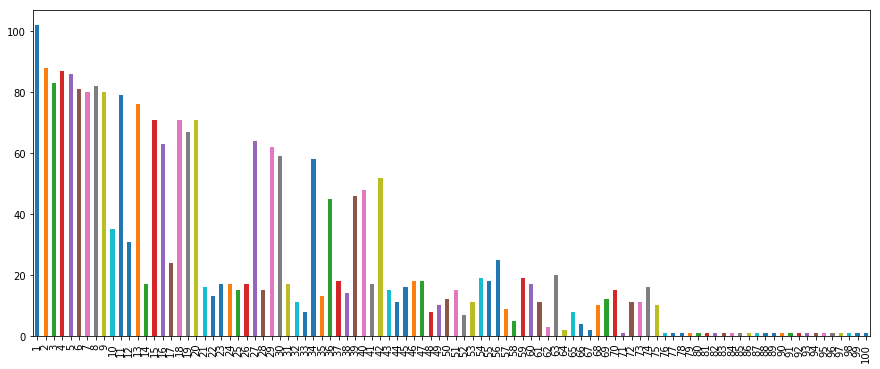

In [99]:
clustering_results['nb of similar neighborhoods'].plot(kind='bar',figsize=(15, 6))

As we can see, the number of 48 clusters used earlier wasn't random, but I carefully choose it to have the lowest number of cluster elements while not increasing too much the number of clusters (below 50). 
And as we have seen when we were discovring the most common venues of the other elements of the cluster, they can be quite similar.  
However, with every new random neighborhood, we have to pick manually the number of clusters to be considered for the remaining part of the analysis.  

Still, with this approach we were able to find a neighborhood that share 4 of its most common categories with the selected neighborhhod

## Conclusion

The clustering approach was able to find a more similar neighborhood sharing 4 of its 10 most common venue categories with the selected NY neighborhood.  
Now the problem of the clustering is the initial number of clusters to use, we have seen i the previous example that it has to be picked manually for each new neighborhood.  
the first approach (euclidain distance) has the advantage of beign more systematic but fails to fnd as good results as the clustering.  
Both approches give some un-relaiable results.  
In conclusion, Depite the initial number of clusters issue, I prefer using the clustering technique.